In [10]:
# ==============================
# Cell 1: Data Classes & Helpers
# ==============================
from typing import List, Optional, Tuple
import math

# -------------------------------
# Haversine distance (km)
# -------------------------------
def haversine(coord1: Tuple[float,float], coord2: Tuple[float,float]) -> float:
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371.0  # Earth radius in km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

# -------------------------------
# Nurse class
# -------------------------------
class Nurse:
    def __init__(self, data: dict):
        self.id: str = data.get("id")
        self.skills: List[str] = data.get("skills", [])
        self.experience_level: float = data.get("experience_level", 0.0)
        self.base_location: Tuple[float,float] = tuple(data.get("base_location", [0.0,0.0]))

        # Dynamic scheduling state
        self.assigned_patients: List[str] = []
        self.assigned_hours: float = 0.0
        self.available_time: float = 0.0
        self.fatigue_level: float = 0.0

    def is_available(self, current_time: float) -> bool:
        return current_time >= self.available_time

    def normalized_fatigue(self) -> float:
        return min(self.fatigue_level / 60.0, 1.0)

# -------------------------------
# Patient class
# -------------------------------
class Patient:
    def __init__(self, data: dict):
        self.id: str = data.get("id")
        self.name: str = data.get("name", "")
        self.location: Tuple[float,float] = tuple(data.get("location", [0.0,0.0]))
        self.care_level: str = data.get("care_level", "low")
        self.remaining_visits: int = data.get("required_visits", 1)
        self.urgency: str = data.get("urgency", "routine")
        self.special_requirements: List[str] = data.get("special_requirements", [])
        self.max_wait_time: float = data.get("max_wait_time", 120)
        self.continuity_preference: bool = data.get("continuity_preference", False)
        self.arrival_time: float = data.get("arrival_time", 0.0)
        self.assigned_nurse: Optional[str] = None
        self.assigned_time: Optional[float] = None
        self.status: str = "waiting"  # waiting / assigned / done

    def waiting_minutes(self, current_time: float) -> float:
        if self.status=="waiting":
            return max(0.0, current_time - self.arrival_time)
        elif self.assigned_time is not None:
            return max(0.0, self.assigned_time - self.arrival_time)
        else:
            return 0.0

# -------------------------------
# Constraints class
# -------------------------------
class Constraints:
    def __init__(self, data: dict):
        self.max_travel_time: float = data.get("max_travel_time", 60.0)  # in minutes
        self.continuity_weight: float = data.get("continuity_weight", 2.0)


In [2]:
# ==============================
# Cell 2: Scheduling Environment
# ==============================

from typing import List, Tuple, Dict, Any
import random
import numpy as np

class SchedulingState:
    def __init__(self, nurses: List[Nurse], patients: List[Patient], constraints: Constraints, current_time: float):
        self.nurses = nurses
        self.patients = patients
        self.constraints = constraints
        self.current_time = current_time

    def nurse_patient_distance(self, nurse: Nurse, patient: Patient) -> float:
        return haversine(nurse.base_location, patient.location)

    def summarize(self):
        print(f"--- Time: {self.current_time:.1f} min ---")
        print("Nurses:")
        for n in self.nurses:
            print(f"  {n.id}: available_at={n.available_time:.1f}, fatigue={n.fatigue_level:.2f}, assigned={n.assigned_patients}")
        print("Patients:")
        for p in self.patients:
            print(f"  {p.id}: status={p.status}, assigned_nurse={p.assigned_nurse}, waits={p.waiting_minutes(self.current_time):.1f}m")


class SchedulingEnv:
    CARE_SERVICE_MIN = {"low":20, "medium":35, "high":50}

    def __init__(self,
                 nurses: List[Nurse],
                 constraints: Constraints,
                 *,
                 step_minutes: int = 5,
                 horizon_min: int = 8*60,
                 travel_speed_kmh: float = 30,
                 poisson_lambda_per_step: float = 1.5,
                 lat_range: Tuple[float,float]=(63.4,63.6),
                 lon_range: Tuple[float,float]=(10.3,10.6),
                 random_seed: int = 42,
                 max_action_dim: int = 200):
        random.seed(random_seed)
        np.random.seed(random_seed)

        self.nurses = nurses
        self.constraints = constraints
        self.time_step = step_minutes
        self.horizon_min = horizon_min
        self.travel_speed_kmh = travel_speed_kmh
        self.poisson_lambda = poisson_lambda_per_step
        self.lat_range = lat_range
        self.lon_range = lon_range
        self.current_time = 0.0
        self._patient_counter = 0
        self.done = False

        self.max_action_dim = max_action_dim
        self.patients: List[Patient] = []
        self.state = SchedulingState(self.nurses, self.patients, self.constraints, self.current_time)


    def _km_to_travel_minutes(self, km: float) -> float:
        speed_km_per_min = self.travel_speed_kmh / 60.0
        return km / max(speed_km_per_min, 1e-6)

    def _service_minutes_for(self, patient: Patient) -> float:
        level = patient.care_level if patient.care_level in self.CARE_SERVICE_MIN else "low"
        return float(self.CARE_SERVICE_MIN[level])

    def _encode_action_mask(self, actions: List[Tuple[str,str,int]]) -> np.ndarray:
        mask = np.zeros(self.max_action_dim, dtype=np.float32)
        for i in range(min(len(actions), self.max_action_dim)):
            mask[i] = 1.0
        return mask

    # ------------------ Reset ------------------
    def reset(self) -> Tuple[SchedulingState, List[Tuple[str,str,int]], np.ndarray]:
        self.current_time = 0.0
        self.done = False
        self._patient_counter = 0
        self.patients.clear()

        for n in self.nurses:
            n.assigned_patients = []
            n.assigned_hours = 0.0
            n.available_time = 0.0
            n.fatigue_level = 0.0

        self.state = SchedulingState(self.nurses, self.patients, self.constraints, self.current_time)
        valid_actions = self.generate_valid_actions()
        valid_mask = self._encode_action_mask(valid_actions)
        return self.state, valid_actions, valid_mask

    # ------------------ Generate Patients ------------------
    def generate_patients(self):
        count = np.random.poisson(self.poisson_lambda)
        for _ in range(count):
            self._patient_counter += 1
            pid = f"p_{self._patient_counter}"
            lat = random.uniform(*self.lat_range)
            lon = random.uniform(*self.lon_range)
            urgency = random.choices(["routine","urgent","emergency"], weights=[0.7,0.25,0.05])[0]
            care = random.choices(["low","medium","high"], weights=[0.5,0.35,0.15])[0]
            reqs = random.sample(["wound_care","medication","elderly care","mobility assistance",
                                  "ICU","emergency","dementia care","physio"], k=random.randint(1,3))
            pdata = {
                "id": pid,
                "name": pid,
                "care_level": care,
                "required_visits": 1,
                "location": [lat, lon],
                "urgency": urgency,
                "special_requirements": reqs,
                "max_wait_time": random.randint(30,120),
                "continuity_preference": random.choice([True,False]),
                "arrival_time": self.current_time
            }
            self.patients.append(Patient(pdata))

    # ------------------ Generate Actions ------------------
    def generate_valid_actions(self) -> List[Tuple[str,str,int]]:
        actions = []
        now = self.current_time
        self.generate_patients()  # generate each step

        available_nurses = [n for n in self.nurses if n.is_available(now)]
        waiting_patients = [p for p in self.patients if p.status=="waiting" and p.remaining_visits>0]

        for n in available_nurses:
            for p in waiting_patients:
                actions.append((n.id, p.id, 0))

        assigned_patients = [p for p in self.patients if p.status=="assigned" and p.remaining_visits>0]
        for n in available_nurses:
            for p in assigned_patients:
                current_nurse = next((x for x in self.nurses if x.id==p.assigned_nurse), None)
                if current_nurse is None or current_nurse.id==n.id:
                    continue
                skill_new = len(set(n.skills).intersection(p.special_requirements))
                skill_old = len(set(current_nurse.skills).intersection(p.special_requirements))
                dist_new = self.state.nurse_patient_distance(n, p)
                dist_old = self.state.nurse_patient_distance(current_nurse, p)
                if (skill_new > skill_old) or (dist_new < dist_old):
                    actions.append((n.id, p.id, 1))
        return actions

    # ------------------ Step ------------------
    def step(self, action: Tuple[str,str,int]) -> Tuple[SchedulingState, float, bool, dict, list, np.ndarray]:
        if self.done:
            return self.state, 0.0, True, {}, [], np.zeros(self.max_action_dim, dtype=np.float32)

        now = self.current_time
        self.generate_patients()

        nurse_id, patient_id, op = action
        nurse = next((n for n in self.nurses if n.id==nurse_id), None)
        patient = next((p for p in self.patients if p.id==patient_id), None)
        reward = 0.0
        info = {}

        if nurse is None or patient is None:
            return self._advance_and_finalize(-5.0, {"error":"invalid ids"})

        if not nurse.is_available(now):
            return self._advance_and_finalize(-5.0, {"error":"nurse busy"})

        distance = self.state.nurse_patient_distance(nurse, patient)
        travel_min = self._km_to_travel_minutes(distance)
        service_min = self._service_minutes_for(patient)
        skill_match = len(set(nurse.skills).intersection(patient.special_requirements))
        continuity_bonus = 2.0 if patient.continuity_preference and patient.id in nurse.assigned_patients else 0.0

        # --- Reward system with skill match ---
        if op==0 and patient.status=="waiting":
            self._assign_patient(nurse, patient, now, travel_min, service_min)
            reward += 5*skill_match - 0.0005* distance - 0.2*min(nurse.fatigue_level/60.0, 1.0) - 0.1*patient.waiting_minutes(now) + continuity_bonus
        elif op==1 and patient.status=="assigned" and patient.assigned_nurse!=nurse.id:
            old_nurse = next((n for n in self.nurses if n.id==patient.assigned_nurse), None)
            if old_nurse and patient.id in old_nurse.assigned_patients:
                old_nurse.assigned_patients.remove(patient.id)
            patient.assigned_nurse = None
            patient.status = "waiting"
            patient.assigned_time = None
            self._assign_patient(nurse, patient, now, travel_min, service_min)
            reward += 2.0 + (5*skill_match - 0.0005* distance) - 0.2*min(nurse.fatigue_level/60.0,1.0) + continuity_bonus
        else:
            return self._advance_and_finalize(-2.0, {"error":"invalid action"})

        for p in self.patients:
            if p.status=="waiting" and p.remaining_visits>0 and p.waiting_minutes(now) > p.max_wait_time:
                reward -= 1.0

        return self._advance_and_finalize(reward, info)

    # ------------------ Internal Assign ------------------
    def _assign_patient(self, nurse: Nurse, patient: Patient, now: float, travel_min: float, service_min: float):
        duration = travel_min + service_min
        nurse.available_time = now + duration
        nurse.fatigue_level += 0.05*duration
        nurse.assigned_hours += duration/60.0
        if patient.id not in nurse.assigned_patients:
            nurse.assigned_patients.append(patient.id)
        patient.status = "assigned"
        patient.assigned_nurse = nurse.id
        patient.assigned_time = now
        patient.remaining_visits = max(0, patient.remaining_visits-1)

    # ------------------ Advance Time ------------------
    def _advance_and_finalize(self, reward: float, info: dict):
        self.current_time += self.time_step
        now = self.current_time

        for p in self.patients:
            if p.status=="assigned" and p.assigned_nurse:
                n = next((x for x in self.nurses if x.id==p.assigned_nurse), None)
                if n and n.is_available(now):
                    p.status="done"

        if now >= self.horizon_min:
            self.done=True

        self.state = SchedulingState(self.nurses, self.patients, self.constraints, self.current_time)
        valid_actions = self.generate_valid_actions()
        valid_mask = self._encode_action_mask(valid_actions)
        return self.state, reward, self.done, info, valid_actions, valid_mask


In [3]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import numpy as np

# -------------------------------
# Config
# -------------------------------
max_nurses = 15
max_patients = 8

# Feature dims
NURSE_BASE_DIM = 4   # [available_time_norm, fatigue_norm, load_norm, experience_norm]
PATIENT_BASE_DIM = 5 # [waiting, remaining_visits_norm, waiting_min_norm, assigned, care_duration_norm]

# Add edge features
EDGE_FEAT_DIM = 2    # [min_dist, max_skill_match]

NURSE_FEAT_DIM = NURSE_BASE_DIM + EDGE_FEAT_DIM
PATIENT_FEAT_DIM = PATIENT_BASE_DIM + EDGE_FEAT_DIM

# ==============================
# PPO Attention / Graph Agent
# ==============================
class AttentionPPOAgent(nn.Module):
    def __init__(self, nurse_feat_dim, patient_feat_dim, max_nurses, max_patients,
                 hidden_dim=128, n_heads=4, n_layers=2, action_dim=200, lr=3e-4):
        super().__init__()
        self.max_nurses = max_nurses
        self.max_patients = max_patients
        self.token_count = max_nurses + max_patients
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim

        # Encoders
        self.nurse_encoder = nn.Linear(nurse_feat_dim, hidden_dim)
        self.patient_encoder = nn.Linear(patient_feat_dim, hidden_dim)

        # Positional embeddings
        self.pos_emb = nn.Parameter(torch.zeros(1, self.token_count, hidden_dim))
        nn.init.normal_(self.pos_emb, std=0.02)

        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=n_heads,
            dim_feedforward=hidden_dim*4, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Actor & Critic
        flat_dim = hidden_dim * self.token_count
        self.actor = nn.Sequential(
            nn.Linear(flat_dim, flat_dim//2),
            nn.ReLU(),
            nn.Linear(flat_dim//2, action_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(flat_dim, flat_dim//2),
            nn.ReLU(),
            nn.Linear(flat_dim//2, 1)
        )

    def forward(self, nurse_tokens, patient_tokens, valid_mask=None):
        B = nurse_tokens.size(0)
        n_enc = self.nurse_encoder(nurse_tokens)
        p_enc = self.patient_encoder(patient_tokens)
        tokens = torch.cat([n_enc, p_enc], dim=1)
        tokens = tokens + self.pos_emb[:, :tokens.size(1), :]
        h = self.transformer(tokens)
        h_flat = h.reshape(B, -1)
        logits = self.actor(h_flat)

        # ---- safe mask ----
        if valid_mask is not None:
            valid_mask = valid_mask.float()

            if valid_mask.sum(dim=1).min() == 0:
                valid_mask[:, 0] = 1.0
            logits = logits.masked_fill(valid_mask == 0, -1e9)
        logits = torch.clamp(logits, -20, 20)  # numerical stability
        value = self.critic(h_flat)
        return logits, value

    def select_action(self, nurse_tokens, patient_tokens, valid_mask):
        if nurse_tokens.dim() == 2:
            nurse_tokens = nurse_tokens.unsqueeze(0)
        if patient_tokens.dim() == 2:
            patient_tokens = patient_tokens.unsqueeze(0)
        if valid_mask.dim() == 1:
            valid_mask = valid_mask.unsqueeze(0)
        logits, value = self.forward(nurse_tokens, patient_tokens, valid_mask)
        dist = Categorical(logits=logits)
        action_idx = dist.sample()
        log_prob = dist.log_prob(action_idx)
        return action_idx.item(), log_prob.detach(), value.squeeze(0).detach()


# -------------------------------
# Structured State Encoder
# -------------------------------
def encode_state_structured(state, max_nurses=max_nurses, max_patients=max_patients):
    # Nurse features
    nurse_base = []
    for n in state.nurses[:max_nurses]:
        nurse_base.append([
            min(n.available_time, 500)/500.0,
            min(n.fatigue_level, 60)/60.0,
            min(len(n.assigned_patients), max_patients)/max_patients,
            min(n.experience_level, 7)/7.0
        ])
    while len(nurse_base) < max_nurses:
        nurse_base.append([0.0]*NURSE_BASE_DIM)
    nurse_base = np.array(nurse_base, dtype=np.float32)

    # Patient features
    patient_base = []
    for p in state.patients[:max_patients]:
        waiting = 1.0 if p.status == "waiting" else 0.0
        assigned = 1.0 if p.assigned_nurse is not None else 0.0
        care_dur = float(SchedulingEnv.CARE_SERVICE_MIN.get(p.care_level, 20))
        patient_base.append([
            waiting,
            min(p.remaining_visits,5)/5.0,
            min(p.waiting_minutes(state.current_time),120)/120.0,
            assigned,
            min(care_dur,120)/120.0
        ])
    while len(patient_base) < max_patients:
        patient_base.append([0.0]*PATIENT_BASE_DIM)
    patient_base = np.array(patient_base, dtype=np.float32)

    # Edge features
    dist_mat = np.zeros((max_nurses,max_patients),dtype=np.float32)
    skill_mat = np.zeros((max_nurses,max_patients),dtype=np.float32)
    for i, n in enumerate(state.nurses[:max_nurses]):
        for j, p in enumerate(state.patients[:max_patients]):
            dist_mat[i,j] = state.nurse_patient_distance(n,p)
            skill_mat[i,j] = len(set(n.skills).intersection(p.special_requirements))
    dist_norm = np.clip(dist_mat/10.0,0,1)
    skill_norm = np.clip(skill_mat/5.0,0,1)

    nurse_tokens = np.concatenate([nurse_base,
                                   dist_norm.min(axis=1, keepdims=True),
                                   skill_norm.max(axis=1, keepdims=True)], axis=1)
    patient_tokens = np.concatenate([patient_base,
                                     dist_norm.min(axis=0, keepdims=True).T,
                                     skill_norm.max(axis=0, keepdims=True).T], axis=1)

    # Valid mask
    valid_mask = build_valid_mask_structured(state, max_nurses, max_patients)
    action_dim = max_nurses*max_patients*2
    if valid_mask.sum() == 0:
        valid_mask[0] = 1.0
    assert valid_mask.shape[0] == action_dim, "valid_mask wrong shape"
    return nurse_tokens, patient_tokens, valid_mask


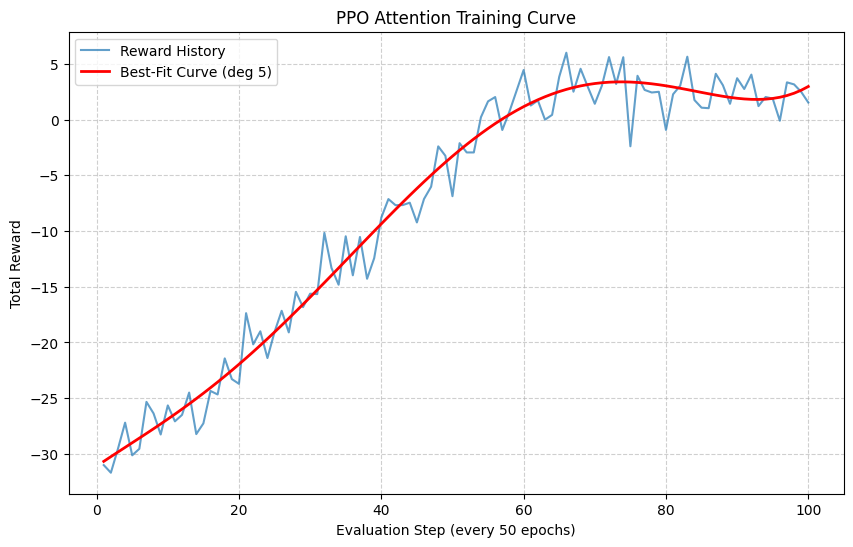

In [8]:
import json
import torch
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# -------------------------------
# Load nurses and constraints
# -------------------------------
with open("/content/drive/MyDrive/NURSESCHEDR/nurses.json") as f:
    nurse_json = json.load(f)
nurses = [Nurse(n) for n in nurse_json]

with open("/content/drive/MyDrive/NURSESCHEDR/constraints.json") as f:
    constraints_data = json.load(f)
constraints = Constraints(constraints_data)

# -------------------------------
# Environment
# -------------------------------
env = SchedulingEnv(
    nurses=nurses,
    constraints=constraints,
    horizon_min=8*60,
    travel_speed_kmh=30,
    poisson_lambda_per_step=0.5,
    # lat_range=(56.39, 62.48),
    # lon_range=(10.30, 4.55),
    random_seed=42
)

# -------------------------------
# PPO Agent
# -------------------------------
action_dim = max_nurses*max_patients*2
agent = AttentionPPOAgent(
    nurse_feat_dim=NURSE_FEAT_DIM,
    patient_feat_dim=PATIENT_FEAT_DIM,
    max_nurses=max_nurses,
    max_patients=max_patients,
    hidden_dim=128,
    n_heads=4,
    n_layers=2,
    action_dim=action_dim,
    lr=3e-4
).to(device)

# -------------------------------
# Helpers
# -------------------------------
def action_index_to_tuple(idx, state, max_n=max_nurses, max_p=max_patients):
    total = max_n*max_p*2
    if idx<0 or idx>=total:
        return None
    pair = idx//2
    op = idx%2
    n_idx = pair//max_p
    p_idx = pair%max_p
    if n_idx>=len(state.nurses) or p_idx>=len(state.patients):
        return None
    return (state.nurses[n_idx].id, state.patients[p_idx].id, int(op))

def build_valid_mask_structured(state, max_n=max_nurses, max_p=max_patients):
    mask = np.zeros(max_n*max_p*2, dtype=np.float32)
    now = state.current_time
    for n_idx in range(max_n):
        for p_idx in range(max_p):
            base_idx = (n_idx*max_p + p_idx)*2
            if n_idx>=len(state.nurses) or p_idx>=len(state.patients):
                continue
            n = state.nurses[n_idx]
            p = state.patients[p_idx]
            if n.is_available(now) and p.status=="waiting" and p.remaining_visits>0:
                mask[base_idx+0]=1.0
            if n.is_available(now) and p.status=="assigned" and p.assigned_nurse != n.id:
                current_nurse = next((x for x in state.nurses if x.id==p.assigned_nurse), None)
                if current_nurse is None:
                    mask[base_idx+1] = 1.0
                else:
                    skill_new = len(set(n.skills).intersection(p.special_requirements))
                    skill_old = len(set(current_nurse.skills).intersection(p.special_requirements))
                    dist_new = state.nurse_patient_distance(n, p)
                    dist_old = state.nurse_patient_distance(current_nurse, p)
                    if (skill_new > skill_old) or (dist_new < dist_old):
                        mask[base_idx+1] = 1.0
    if mask.sum() == 0:
        mask[0] = 1.0
    return mask

# -------------------------------
# PPO Training Loop
# -------------------------------
def train_ppo_attention(env, agent, num_episodes=50, rollout_length=32,
                        gamma=0.99, clip_eps=0.2, value_coef=0.5, entropy_coef=0.01,
                        ppo_epochs=4, max_n=max_nurses, max_p=max_patients,
                        device="cpu", plot=True):

    optimizer = torch.optim.Adam(agent.parameters(), lr=3e-4)
    reward_history = []

    for ep in range(num_episodes):
        state, _, _ = env.reset()
        done = False
        t = 0

        nurse_buf, patient_buf = [], []
        action_idx_buf, old_logprob_buf = [], []
        reward_buf, mask_buf, valid_mask_buf = [], [], []

        while not done and t < rollout_length:
            n_feats, p_feats, valid_mask_np = encode_state_structured(state, max_n, max_p)
            nurse_tensor = torch.tensor(n_feats, dtype=torch.float32, device=device).unsqueeze(0)
            patient_tensor = torch.tensor(p_feats, dtype=torch.float32, device=device).unsqueeze(0)
            mask_tensor = torch.tensor(valid_mask_np, dtype=torch.float32, device=device).unsqueeze(0)

            with torch.no_grad():
                logits, value = agent(nurse_tensor, patient_tensor, valid_mask=mask_tensor)
                dist = Categorical(logits=logits)
                action_idx = dist.sample()
                logprob = dist.log_prob(action_idx)

            idx_int = int(action_idx.item())
            action_tuple = action_index_to_tuple(idx_int, state, max_n, max_p)
            if action_tuple is None:
                next_state, reward, done_flag, _, _, _ = env.step(("", "", 0))
            else:
                next_state, reward, done_flag, _, _, _ = env.step(action_tuple)

            # Store rollout
            nurse_buf.append(nurse_tensor)
            patient_buf.append(patient_tensor)
            action_idx_buf.append(action_idx)
            old_logprob_buf.append(logprob)
            reward_buf.append(float(reward))
            mask_buf.append(0.0 if done_flag else 1.0)
            valid_mask_buf.append(mask_tensor)

            state = next_state
            done = bool(done_flag)
            t += 1

        # Stack rollout tensors
        nurse_tensor = torch.cat(nurse_buf, dim=0).squeeze(1)
        patient_tensor = torch.cat(patient_buf, dim=0).squeeze(1)
        action_tensor = torch.stack(action_idx_buf).long().to(device)
        old_logprob_tensor = torch.stack(old_logprob_buf).to(device)
        reward_tensor = torch.tensor(reward_buf, dtype=torch.float32, device=device)
        mask_tensor = torch.tensor(mask_buf, dtype=torch.float32, device=device)
        valid_mask_tensor = torch.cat(valid_mask_buf, dim=0).squeeze(1).to(device)

        # Compute returns & advantages
        returns, G = [], 0.0
        for r, m in zip(reversed(reward_buf), reversed(mask_buf)):
            G = r + gamma * G * m
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32, device=device)
        advantages = returns - reward_tensor

        # PPO update
        for _ in range(ppo_epochs):
            logits, values = agent(nurse_tensor, patient_tensor, valid_mask=valid_mask_tensor)
            dist = Categorical(logits=logits)
            new_logprob = dist.log_prob(action_tensor)
            entropy = dist.entropy().mean()

            ratio = (new_logprob - old_logprob_tensor).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1-clip_eps, 1+clip_eps) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = (returns - values.squeeze(-1)).pow(2).mean()
            loss = policy_loss + value_coef*value_loss - entropy_coef*entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        reward_history.append(sum(reward_buf))
        if (ep+1)%50==0:
            print(f"Episode {ep+1}/{num_episodes} | Reward: {reward_history[-1]:.2f}")

    if plot:
        n_values = 100
        x = np.arange(1, n_values+1)
        degree = 5
        coeffs = np.polyfit(x, reward_history, degree)
        poly_fit = np.poly1d(coeffs)
        best_fit_curve = poly_fit(x)


        plt.figure(figsize=(10, 6))
        plt.plot(x, reward_history, label="Reward History", alpha=0.7)
        plt.plot(x, best_fit_curve, label=f"Best-Fit Curve (deg {degree})", linewidth=2, color="red")
        plt.xlabel("Evaluation Step (every 50 epochs)")
        plt.ylabel("Total Reward")
        plt.title("PPO Attention Training Curve")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.show()

# -------------------------------
# Run Training
# -------------------------------
train_ppo_attention(env, agent, num_episodes=5000, rollout_length=32, device=device)


Nurses and constraints data - https://drive.google.com/drive/folders/1_20kY6Jfae49bJiXOeZK1gY8G3cg0t_i?usp=sharing
